# 5　クラスタリング

## A　階層的クラスタリング
階層的クラスタリングは先にデンドログラムと呼ばれる、横軸にデータポイントのindex, 縦軸にクラスターの間の距離を用いたグラフを描き、そのグラフを参考に自分でどのようなクラスターにまとめ上げるかを決める方法です。今回は`scipy.cluster.hierarchy`を用いて、階層型クラスタリングをやってみましょう。

### 各国の乳製品の消費量のデータ
各国の乳製品の消費量のデータを持ちいて、消費量による国のクラスタリングをやってみましょう。

In [1]:
import pandas as pd
data = pd.read_csv("./data/dairy_products.csv")
data.head(n = 5)

,country,butter,milk,cheese
0,中国,0.1,20.3,0.1
1,日本,0.6,30.8,2.4
2,韓国,0.2,32.9,2.8
3,イラン,1.0,27.1,4.7
4,トルコ,0.9,17.8,7.8


In [2]:
data.describe()

,butter,milk,cheese
count,46.000000,46.000000,46.000000
mean,2.576087,56.641304,13.293478
std,1.953024,29.652203,8.526518
min,0.100000,9.100000,0.100000
25%,0.925000,33.275000,4.950000
50%,2.300000,49.600000,13.300000
75%,3.675000,77.650000,19.950000
max,8.200000,125.000000,28.100000


In [3]:
# dendrogramを分かりやすくするのに必要なので、各データポイントのラベルを1次元配列で準備する。
country = data["country"].values

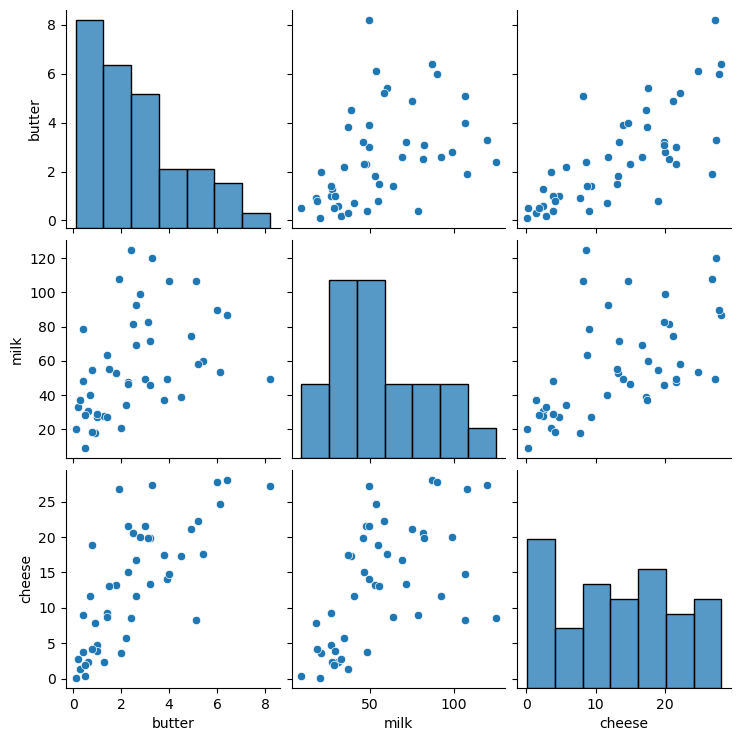

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.pairplot(data)
plt.show()

In [5]:
# 入力の2次元配列を作る。
X = data.drop("country", axis = 1).values
X.shape

(46, 3)

### 各列のスケールをそろえる
消費量の標準偏差は、各乳製品ごとに異なります。階層クラスタリングを行う前にスケールをそろえておきましょう。

In [6]:
# データを標準化する。（最小値０、最大１にする。）
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X) #最大値、最小値を求める。
X_scaled = scaler.transform(X)

### dendrogramを描く
階層クラスタリングは`linkage` methodで計算でき、`dendrogram` methodで可視化できます。なお、`matplotlib.pyplot`はそのままでは日本語に対して文字化けを起こしますが、`japanize-matplotlib`をimportすると回避できるのでやっておきましょう。

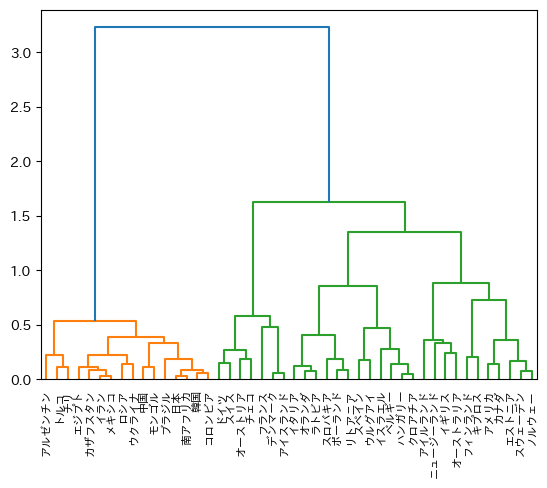

In [7]:
# 凝集型階層クラスタリングの計算と結果
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import japanize_matplotlib    # pip install japanize-matplotlib

result = linkage(X_scaled, method = "ward")
dendrogram(result, labels = country)
plt.show()

勝手についている色は特に気にしないでください。（見やすさを意識して、ただ勝手についているだけです。）例えば、縦軸の値が1.0のあたりで分割すると、良い感じにクラスターになるなと思ったとしましょう。その場合次のようにしてクラスターのidを各国に割り当てます。


In [8]:
# クラスターの計算
from scipy.cluster.hierarchy import fcluster
cluster = fcluster(result, t = 1, criterion = "distance")
cluster

array([1, 1, 1, 1, 1, 3, 1, 1, 4, 2, 3, 2, 3, 3, 4, 3, 4, 2, 4, 2, 3, 2,
       3, 3, 3, 4, 3, 3, 4, 4, 1, 4, 1, 1, 1, 1, 3, 1, 1, 2, 4, 2, 1, 1,
       4, 4], dtype=int32)

各clusterの特徴をpairplotで確認すると、次のようなことが分かります。

* cluster 1 : 乳製品をあまり消費しない国
* cluster 2 : milkよりbutter, cheeseでしょ！
* cluster 3 : butter, milkよりcheeseでしょ！
* cluster 4 : 牛乳の大量消費国

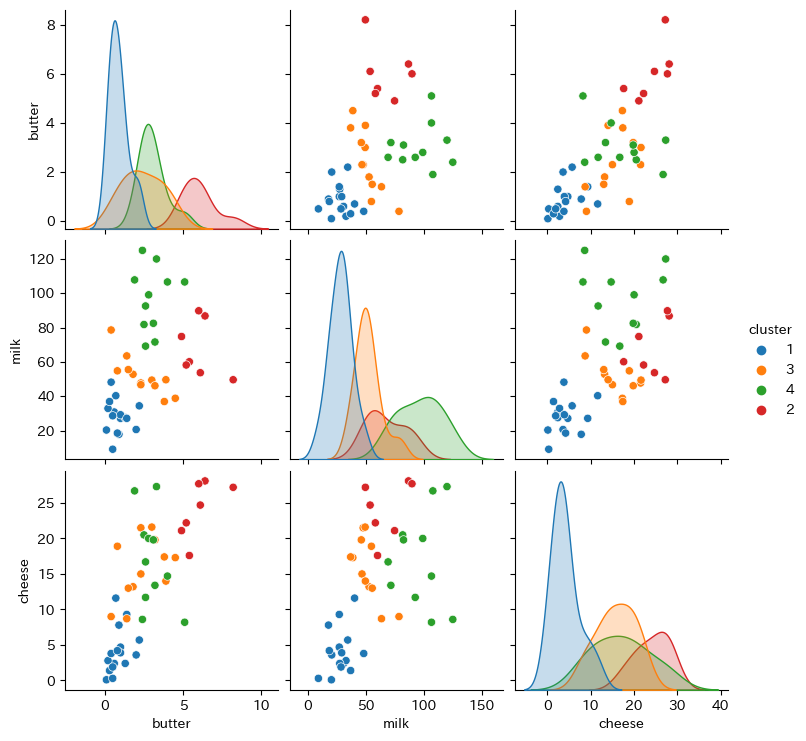

In [9]:
data = data.assign(cluster = cluster)
data["cluster"] = data["cluster"].astype("str")    # cluster列を数値から文字列にcast
sns.pairplot(data, hue = "cluster")
plt.show()

各clusterに所属している国を確認すると更に面白いでしょう。例えばcluster 4は次のようになっています。アメリカやオーストラリアが属しているあたりに、牛乳大量消費国というクラスターの特徴の納得感がありますね。

In [10]:
data.query('cluster == "4"')

,country,butter,milk,cheese,cluster
8,イギリス,2.6,92.6,11.7,4
14,スウェーデン,2.5,81.8,20.5,4
16,フィンランド,3.3,120.0,27.3,4
18,アイルランド,2.4,125.0,8.6,4
25,エストニア,2.8,99.1,20.0,4
28,キプロス,1.9,107.8,26.7,4
29,アメリカ,2.6,69.2,16.7,4
31,カナダ,3.2,71.6,13.4,4
40,ノルウェー,3.1,82.5,19.8,4
44,オーストラリア,4.0,106.6,14.7,4


**演習**　上では階層型クラスタリングのうち特にWard法と呼ばれるものを紹介しました。`linkage` methodの引数`method`に`ward`を指定した部分がこの選択に対応します。他にも
* `single` : 最短距離法
* `complete` : 最長距離法
* `centroid` : 重心法

などがあります。さて、dairy_productsデータに対して，

(1) linkageの引数**method**を変更し，デンドログラムをかきましょう．

(2) 描画されたデンドログラムを比較し，うまくクラスタリングできているのはどれか，検討しましょう．

## B　DBSCAN
ここまでで見たクラスタリングの手法はどちらも，「距離が近いデータポイントは同じクラスタに属すると考える」という共通点があります．

距離ではなく，密度に注目してクラスタリングを行う手法を紹介します．

#### DBSCANの計算
重要な引数は次の2つです．
 * eps
 * min_samples
 
epsとmin_samplesの値に基づいて，データポイントを**コア点**・**到達可能点**・**外れ値**の3種類に分け，共通したコア点から到達可能な点どうしを同じクラスターに属するとしてまとめ上げる手法．

* コア点：半径eps以内min_samples以上の点が存在するような点．
* 到達可能点：あるコア点の半径eps以内に入っているような点．コア点は特に到達可能点でもあります．
* 外れ値：どんな点からも到達可能ではない点．外れ値はいずれのクラスターにも属さないことになる．

<img src="./imgs/DBSCAN.png">

#### sklearnによる実行
fit_preedictメソッドで予測クラスターが計算されます．<br>
このとき，noiseに分類された点は-1が返されます．<br>

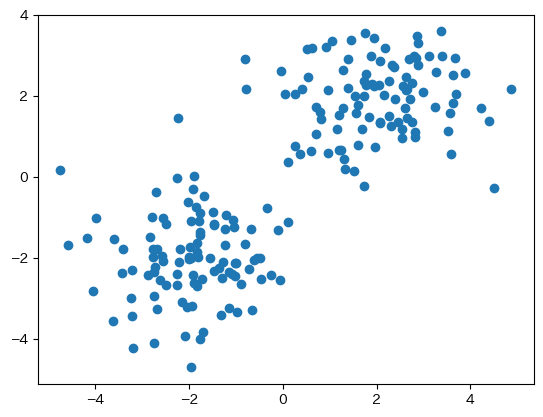

In [11]:
import numpy as np
# デモデータの生成
cluster_0 = np.random.multivariate_normal([-2, -2], [[1, 0], [0, 1]], 100)
cluster_1 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], 100)
X = np.r_[cluster_0, cluster_1]
 
# 散布図
plt.scatter(X[:,0], X[:,1])
plt.show()

In [12]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 1, min_samples = 4)
cluster_dbscan = dbscan.fit_predict(X)
np.unique(cluster_dbscan, return_counts = True)

(array([-1,  0,  1]), array([ 3, 98, 99]))

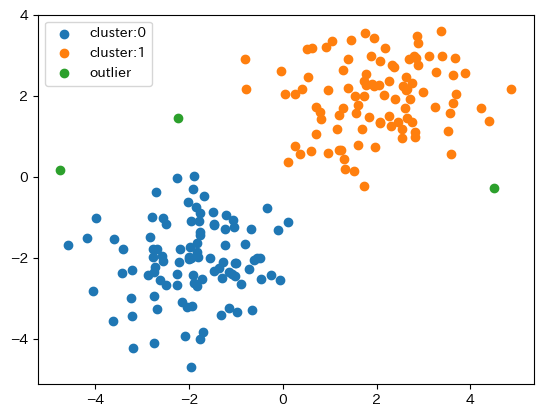

In [13]:
# 結果の可視化
cluster_0 = np.where(cluster_dbscan == 0)
cluster_1 = np.where(cluster_dbscan == 1)
outlier = np.where(cluster_dbscan == -1)

plt.scatter(X[cluster_0, 0], X[cluster_0, 1], label = "cluster:0")
plt.scatter(X[cluster_1, 0], X[cluster_1, 1], label = "cluster:1")
plt.scatter(X[outlier, 0], X[outlier, 1], label = "outlier")

plt.legend()
plt.show()

**演習**<br>
moonデータセットを用いて，ここまでで紹介したクラスタリング手法の演習を行いましょう．<br>
手法によってどのような違いが現れるでしょうか．クラスタリングの結果を散布図上に表現して，比較してみましょう．

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# moon datasetの準備
from sklearn.datasets import make_moons
X, y = make_moons(100, noise = 0.1)

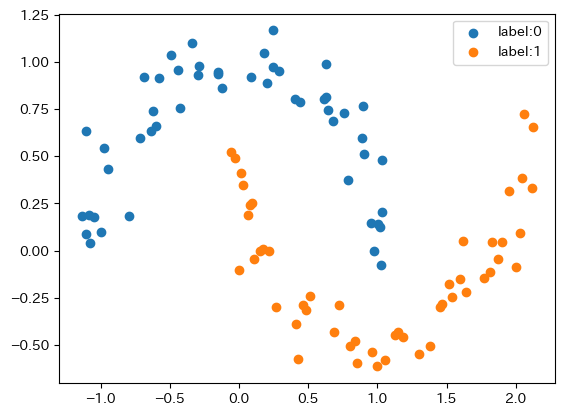

In [16]:
# moon datasetの可視化
index_0 = np.where(y == 0)
index_1 = np.where(y == 1)
plt.scatter(X[index_0, 0], X[index_0, 1], label = "label:0")
plt.scatter(X[index_1, 0], X[index_1, 1], label = "label:1")
plt.legend()
plt.show()

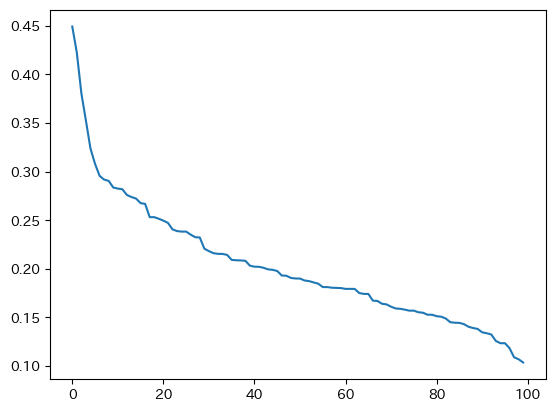

In [17]:
# k-dist（k = 5の場合）の計算
from sklearn.neighbors import NearestNeighbors
k = 5

nn = NearestNeighbors(n_neighbors = k)
nn.fit(X)
distances, _ = nn.kneighbors(X)

# sorted k-dist グラフの計算
distances = distances[:, (k-1)]
distances = np.sort(distances)[::-1]
plt.plot(distances)
plt.show()

In [20]:
from kneed import KneeLocator
kneedle = KneeLocator(x = np.arange(distances.shape[0]),
                      y = distances, 
                      curve = "convex",
                      direction = "decreasing")
kneedle.elbow

9

In [21]:
distances[17]

0.2531951574375622

In [22]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.243, min_samples = 5)
cluster_dbscan = dbscan.fit_predict(X)
cluster_dbscan

array([ 0,  1,  2,  2,  1,  1,  3,  1,  4,  2,  3,  1,  1,  1,  2,  3,  2,
        0,  1,  3,  1,  1, -1,  1,  2,  1, -1,  2,  1, -1,  0,  1, -1,  2,
        2,  3,  0,  2,  2, -1,  1,  3,  1,  2,  1,  2,  1, -1,  1,  2,  1,
        1,  2,  1,  2,  4,  1,  2,  0,  3,  1,  0,  2,  1,  2,  2,  2,  1,
        2,  2,  3, -1,  1,  2,  1,  2,  1,  2,  2,  1,  4,  2,  2, -1,  4,
        3,  2,  2,  2,  3,  1,  3,  4,  1,  4,  2,  1,  4,  2,  3])

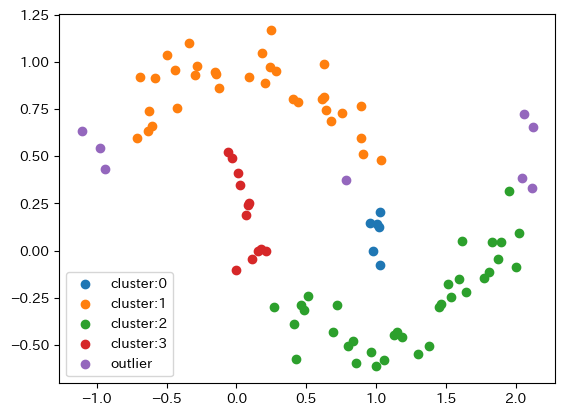

In [23]:
# 結果の可視化
cluster_0 = np.where(cluster_dbscan == 0)
cluster_1 = np.where(cluster_dbscan == 1)
cluster_2 = np.where(cluster_dbscan == 2)
cluster_3 = np.where(cluster_dbscan == 3)
outlier = np.where(cluster_dbscan == -1)

plt.scatter(X[cluster_0, 0], X[cluster_0, 1], label = "cluster:0")
plt.scatter(X[cluster_1, 0], X[cluster_1, 1], label = "cluster:1")
plt.scatter(X[cluster_2, 0], X[cluster_2, 1], label = "cluster:2")
plt.scatter(X[cluster_3, 0], X[cluster_3, 1], label = "cluster:3")
plt.scatter(X[outlier, 0], X[outlier, 1], label = "outlier")

plt.legend()
plt.show()

/Users/sugakubunka/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


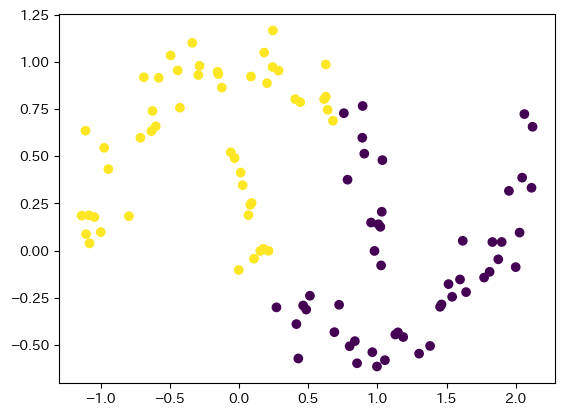

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, max_iter = 100)
kmeans.fit(X)
cluster_kmeans = kmeans.predict(X)
plt.scatter(X[:,0], X[:,1], c = cluster_kmeans)
plt.show()

In [25]:
#正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

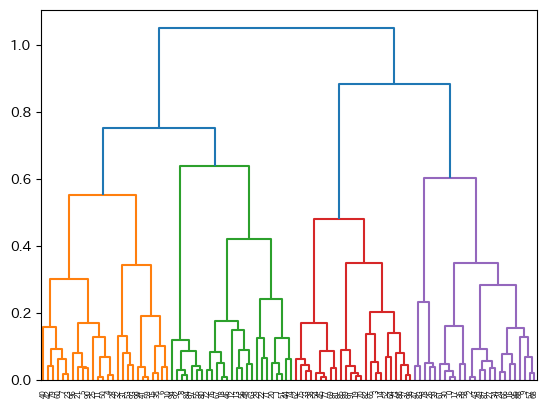

In [26]:
from scipy.cluster.hierarchy import linkage, dendrogram
result = linkage(X_scaled, method = "complete")
dendrogram(result)
plt.show()

In [27]:
# クラスターの計算
from scipy.cluster.hierarchy import fcluster
cluster = fcluster(result, t = 0.9, criterion = "distance")
np.unique(cluster, return_counts = True)

(array([1, 2], dtype=int32), array([51, 49]))

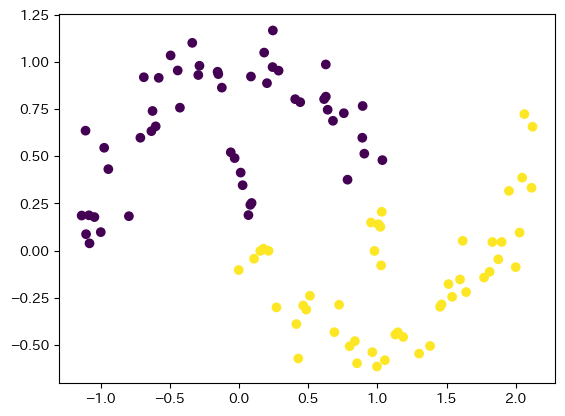

In [28]:
plt.scatter(X[:,0], X[:,1], c = cluster)
plt.show()

### k-dists graph

DBSCANのハイパーパラメータ評価法として、k-dists graphとよばれるものがあります。各データ点からk番目に近い点との距離をk-distとよび、それを小さい順に並べ縦軸にとったものをk-dists graphとよびます。急激にk-distが上昇するところをepsとして設定し、kをmin_samplesとして設定すると良いとされています。


/var/folders/67/k1_dbp1s1cjbdscpkhtjbj000000gn/T/ipykernel_35682/1556482764.py:10: RuntimeWarning: invalid value encountered in sqrt
  p = np.sqrt(p) #i行j列がxiとxjのユークリッド距離になったdim0×dim0行列


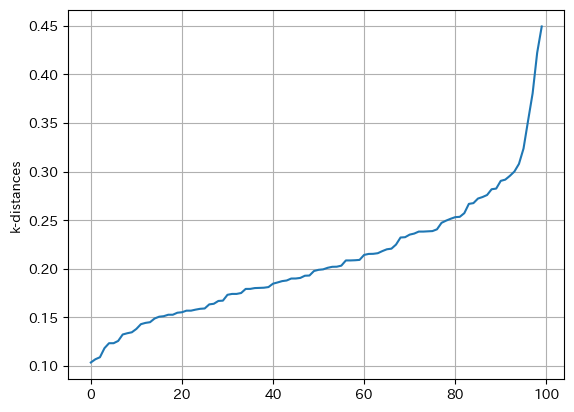

In [29]:
def k_distances(x, k):#各点のk番目に近い点との距離を小さい順に出力
    
    dim0 = x.shape[0]
    
    #x.dot(x.T)=dim0×dim0行列で各行の内積の組み合わせ
    #np.sum(x**2, axis=1).T = dim0×1で行の平方和の1次元配列
    #np.repeat(np.sum(x**2, axis=1),dim0,axis=0)reshape(dim0,dim0) = dim0×dim0で各行の平方和を横にもdim0個
    p=-2*x.dot(x.T)+np.sum(x**2, axis=1).T+ np.repeat(np.sum(x**2, axis=1),dim0,axis=0).reshape(dim0,dim0)
    
    p = np.sqrt(p) #i行j列がxiとxjのユークリッド距離になったdim0×dim0行列
    p.sort(axis=1) #各行を小さい順にソート
    p=p[:,k] #k番目に小さい距離たち
    p.sort() #小さい順にソート
    return p

m = k_distances(X, 4) # k=min_samples、これを変えながら適切なkを探す。
plt.plot(m)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

In [30]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.27, min_samples = 4)
cluster_dbscan = dbscan.fit_predict(X)
np.unique(cluster_dbscan, return_counts = True)

(array([-1,  0,  1,  2,  3,  4]), array([ 2,  6, 37, 36, 12,  7]))

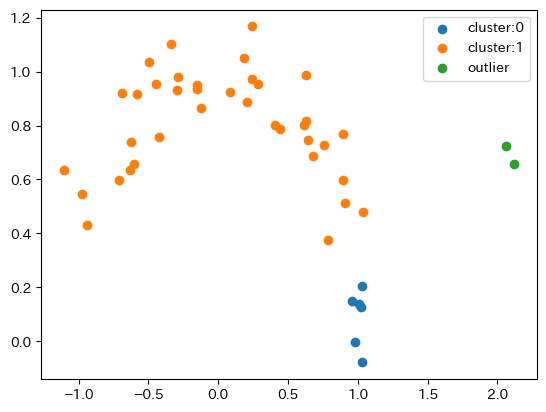

In [31]:
cluster_0 = np.where(cluster_dbscan == 0)
cluster_1 = np.where(cluster_dbscan == 1)
outlier = np.where(cluster_dbscan == -1)

plt.scatter(X[cluster_0, 0], X[cluster_0, 1], label = "cluster:0")
plt.scatter(X[cluster_1, 0], X[cluster_1, 1], label = "cluster:1")
plt.scatter(X[outlier, 0], X[outlier, 1], label = "outlier")

plt.legend()
plt.show()

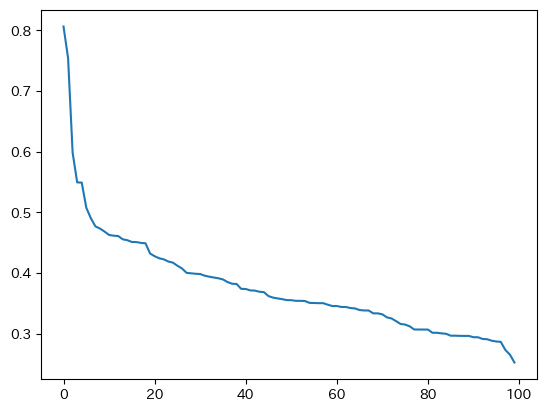

In [32]:
# k-dist（k = 5の場合）の計算
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
k = 10

nn = NearestNeighbors(n_neighbors = k)
nn.fit(X)
distances, _ = nn.kneighbors(X)

# sorted k-dist グラフの計算
distances = distances[:, (k-1)]
distances = np.sort(distances)[::-1]
plt.plot(distances)
plt.show()

In [33]:
from kneed import KneeLocator
kneedle = KneeLocator(x = np.arange(distances.shape[0]),
                      y = distances, 
                      curve = "convex",
                      direction = "decreasing")
kneedle.elbow

7